Skintone Recognition Model 

In [99]:
import os
import cv2
import numpy as np
import pandas as pd
from PIL import Image
from tqdm import tqdm
import tensorflow as tf
from imageio import imread
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

from keras.optimizers import Adam
from keras.utils import to_categorical
from keras.models import Sequential, Model 
from keras.applications import MobileNetV2
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.applications.mobilenet_v2 import preprocess_input
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Input, Embedding, LSTM, Concatenate

Loading Images to Array

In [100]:
def load_images_to_array(folder_path):
    image_list = []
    
    # Loop through all files in the folder
    for filename in os.listdir(folder_path):
        # Check if the file is an image (you can add more specific image formats if needed)
        if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.gif')):
            try:
                # Open the image file
                image_path = os.path.join(folder_path, filename)
                with Image.open(image_path) as img:
                    # Convert the image to a NumPy array
                    img_array = np.array(img)
                    
                    # Append the image array to the list
                    image_list.append(img_array)
                    print(f"Loaded: {filename}")
            except Exception as e:
                print(f"Error loading {filename}: {e}")
    
    return image_list

if __name__ == "__main__":
    # Set the path to the folder containing images
    folder_path = 'E:\\University\\FYP Stuff\\Dataset\\mst-e_data\\mst_faces_resized'
    # folder_path = 'C:\\NUST\\7th Semester\\Computer Vision\\CV proj\\mst_faces_resized'
    
    # Load images from the folder into a list of NumPy arrays
    images_as_arrays = load_images_to_array(folder_path)
    
    #'images_as_arrays' contains NumPy arrays of all the images

Loaded: 10_poorly_lit_PXL_20220922_175703876.jpg
Loaded: 10_poorly_lit_PXL_20220922_175705794.jpg
Loaded: 10_poorly_lit_PXL_20220922_175707910.jpg
Loaded: 10_poorly_lit_PXL_20220922_175709463.jpg
Loaded: 10_poorly_lit_PXL_20220922_175710848.jpg
Loaded: 10_poorly_lit_PXL_20220922_175712230.jpg
Loaded: 10_poorly_lit_PXL_20220922_175713987.jpg
Loaded: 10_poorly_lit_PXL_20220922_175715255.jpg
Loaded: 10_poorly_lit_PXL_20220922_175716367.jpg
Loaded: 10_poorly_lit_PXL_20220922_175718926.jpg
Loaded: 10_poorly_lit_PXL_20220922_175722948.jpg
Loaded: 10_poorly_lit_PXL_20220922_175724422.jpg
Loaded: 10_poorly_lit_PXL_20220922_175725538.jpg
Loaded: 10_poorly_lit_PXL_20220922_175726916.jpg
Loaded: 10_poorly_lit_PXL_20220922_175728401.jpg
Loaded: 10_poorly_lit_PXL_20220922_175732630.jpg
Loaded: 10_poorly_lit_PXL_20220922_175733830.jpg
Loaded: 10_poorly_lit_PXL_20220922_175735218.jpg
Loaded: 10_poorly_lit_PXL_20220922_175736529.jpg
Loaded: 10_poorly_lit_PXL_20220922_175737649.jpg
Loaded: 10_poorly_li

Making Array of Labels

In [101]:
# Path to the folder containing images
folder_path = 'E:\\University\\FYP Stuff\\Dataset\\mst-e_data\\mst_faces_resized'
# folder_path = 'C:\\NUST\\7th Semester\\Computer Vision\\CV proj\\mst_faces_resized'

# Initialize an empty list to store labels
labels = []
lighting = []
# Iterate through all files in the folder
for filename in os.listdir(folder_path):
    # Check if the file is an image (you can add more specific image formats if needed)
    if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.gif')):
        # Extracting the label from the image filename
        label = filename.split('_')[0]
        labels.append(label)
        light = filename.split('_')[1]
        lighting.append(light)

labels = np.array(labels, dtype=np.int32)

# To make output between the range 0-9
labels = labels - 1
# Printing the extracted labels
print(f"Length of Labels array: {len(labels)}")
print("Extracted Labels:", labels)
print(f"Length of Lighting array: {len(lighting)}")
print("Extracted Lightings:", lighting)

Length of Labels array: 1052
Extracted Labels: [9 9 9 ... 8 8 8]
Length of Lighting array: 1052
Extracted Lightings: ['poorly', 'poorly', 'poorly', 'poorly', 'poorly', 'poorly', 'poorly', 'poorly', 'poorly', 'poorly', 'poorly', 'poorly', 'poorly', 'poorly', 'poorly', 'poorly', 'poorly', 'poorly', 'poorly', 'poorly', 'poorly', 'poorly', 'poorly', 'poorly', 'poorly', 'poorly', 'poorly', 'poorly', 'poorly', 'poorly', 'poorly', 'poorly', 'poorly', 'poorly', 'poorly', 'poorly', 'poorly', 'poorly', 'poorly', 'well', 'well', 'well', 'well', 'well', 'well', 'well', 'well', 'well', 'well', 'well', 'well', 'well', 'well', 'well', 'well', 'well', 'well', 'well', 'well', 'well', 'well', 'well', 'well', 'well', 'well', 'well', 'well', 'well', 'well', 'well', 'well', 'well', 'well', 'well', 'well', 'well', 'well', 'well', 'well', 'well', 'well', 'well', 'well', 'poorly', 'poorly', 'poorly', 'poorly', 'poorly', 'poorly', 'poorly', 'poorly', 'poorly', 'poorly', 'poorly', 'poorly', 'poorly', 'poorly', 

Normalizing Picture Array

In [102]:
# normalizing the pictures array (0->255 converted to -1->1)

images_as_arrays_normalized = [preprocess_input(image) for image in images_as_arrays]
#Length of array (number of images)
print(f"length of image array: {len(images_as_arrays_normalized)}")

length of image array: 1052


In [103]:
#Assigning Variables for ease
dataset_path = 'E:\\University\\FYP Stuff\\Dataset\\mst-e_data\\mst_faces_resized'
# dataset_path = 'C:\\NUST\\7th Semester\\Computer Vision\\CV proj\\mst_faces_resized'
input_shape = (224, 224, 3)
image_input = Input(shape=input_shape, name='image_input')
classes = ['MST 1', 'MST 2', 'MST 3', 'MST 4', 'MST 5', 'MST 6', 'MST 7', 'MST 8', 'MST 9', 'MST 10']

epochs = 120  
batch_size = 32

Data splitting (Train and Test)

In [104]:
X_train, X_temp, y_train, y_temp, lighting_train, lighting_temp = train_test_split(images_as_arrays_normalized, labels, lighting, test_size=0.2, random_state=69)

# Further split the temporary set into training and validation (50% of temp, 50% validation)
X_test, X_val, y_test, y_val, lighting_test, lighting_val = train_test_split(X_temp, y_temp, lighting_temp, test_size=0.5, random_state=69)

# Convert to NumPy arrays (if not already)
X_train = np.array(X_train)
X_val = np.array(X_val)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_val = np.array(y_val)
y_test = np.array(y_test)
lighting_train = np.array(lighting_train)
lighting_val = np.array(lighting_val)
lighting_test = np.array(lighting_test)

# Print the shapes of the sets
print(f"X_train Shape: {X_train.shape}")
print(f"y_train Shape: {y_train.shape}")
print(f"lighting_train Shape: {lighting_train.shape}\n")

print(f"X_val Shape: {X_val.shape}")
print(f"y_val Shape: {y_val.shape}")
print(f"lighting_val Shape: {lighting_val.shape}\n")

print(f"X_test Shape: {X_test.shape}")
print(f"y_test Shape: {y_test.shape}")
print(f"lighting_test Shape: {lighting_test.shape}")


X_train Shape: (841, 224, 224, 3)
y_train Shape: (841,)
lighting_train Shape: (841,)

X_val Shape: (106, 224, 224, 3)
y_val Shape: (106,)
lighting_val Shape: (106,)

X_test Shape: (105, 224, 224, 3)
y_test Shape: (105,)
lighting_test Shape: (105,)


In [105]:
base_model = MobileNetV2(input_shape=input_shape, 
                         include_top=False, 
                         weights='imagenet') #top layer exlcuded
base_model.trainable = False #Freezes the Layers (Weights won't get updated)

In [106]:
#Definig Text input layer
text_input = Input(shape=(3,), name='text_input')
text_embedding = Embedding(3, 8)(text_input)
text_lstm = LSTM(64)(text_embedding)

For Multimodal Model

In [107]:
# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform lighting labels
lighting_train_encoded = label_encoder.fit_transform(lighting_train)
lighting_val_encoded = label_encoder.transform(lighting_val)
lighting_test_encoded = label_encoder.transform(lighting_test)

# Convert lighting labels to one-hot encoding
lighting_train_onehot = to_categorical(lighting_train_encoded, num_classes=3)
lighting_val_onehot = to_categorical(lighting_val_encoded, num_classes=3)
lighting_test_onehot = to_categorical(lighting_test_encoded, num_classes=3)

In [108]:
print(lighting_train_onehot.shape)
print(lighting_test_onehot.shape)
print(lighting_val_onehot.shape)

(841, 3)
(105, 3)
(106, 3)


In [109]:
# Extract image features using the base model
image_features = GlobalAveragePooling2D()(base_model(image_input))

# Concatenate image and text features
concatenated = Concatenate()([image_features, text_lstm])

# Define output layer
output = Dense(len(classes), activation='softmax')(concatenated)

# Create multimodal model
model = Model(inputs=[image_input, text_input], 
              outputs=output)

# Compile model
model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])


For Model

In [9]:
# model = Sequential([
#     base_model,
#     GlobalAveragePooling2D(),
#     Dense(256, activation='relu'),
#     Dropout(0.4),
#     Dense(len(classes), activation='softmax')
# ])

# model.compile(optimizer=Adam(lr=1e-4), 
#               loss='sparse_categorical_crossentropy', 
#               metrics=['accuracy'])

c:\Users\Danial1\.conda\envs\MyFirstEnv\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Adding Callbacks 

In [110]:
lr_scheduler = ReduceLROnPlateau(factor=0.5, patience=3, min_lr=1e-6) #Reduces learning rate when no improvment in validation loss
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)  #Stops when we see no improvement

In [111]:
# Train model
history = model.fit(
    {'image_input': X_train, 'text_input': lighting_train_onehot}, 
    y_train, 
    epochs=epochs, 
    batch_size=batch_size, 
    validation_data=({'image_input': X_val, 'text_input': lighting_val_onehot}, y_val),
    callbacks=[lr_scheduler, early_stopping])

# Evaluate model
loss, accuracy = model.evaluate({'image_input': X_test, 'text_input': lighting_test_onehot}, y_test)
print('Test Loss:', loss)
print('Test Accuracy:', accuracy)

Epoch 1/120
27/27 [==============================] - 13s 319ms/step - loss: 2.0645 - accuracy: 0.2925 - val_loss: 1.5408 - val_accuracy: 0.4340 - lr: 0.0010
Epoch 2/120
27/27 [==============================] - 7s 265ms/step - loss: 1.2934 - accuracy: 0.6100 - val_loss: 1.1574 - val_accuracy: 0.6226 - lr: 0.0010
Epoch 3/120
27/27 [==============================] - 7s 253ms/step - loss: 0.9261 - accuracy: 0.7717 - val_loss: 0.9466 - val_accuracy: 0.7547 - lr: 0.0010
Epoch 4/120
27/27 [==============================] - 8s 283ms/step - loss: 0.7331 - accuracy: 0.8228 - val_loss: 0.7910 - val_accuracy: 0.8302 - lr: 0.0010
Epoch 5/120
27/27 [==============================] - 7s 277ms/step - loss: 0.5910 - accuracy: 0.8799 - val_loss: 0.6824 - val_accuracy: 0.8302 - lr: 0.0010
Epoch 6/120
27/27 [==============================] - 7s 269ms/step - loss: 0.4919 - accuracy: 0.9120 - val_loss: 0.6052 - val_accuracy: 0.8774 - lr: 0.0010
Epoch 7/120
27/27 [==============================] - 7s 267ms/s

In [11]:
# history = model.fit(X_train, 
#                     y_train, 
#                     validation_data=(X_val, y_val), 
#                     epochs= epochs, 
#                     batch_size= batch_size,
#                     callbacks=[lr_scheduler, early_stopping]
#                     )

# test_loss, test_accuracy = model.evaluate(X_test, y_test)

Epoch 1/120
27/27 [==============================] - 10s 276ms/step - loss: 2.4778 - accuracy: 0.1374 - val_loss: 2.0264 - val_accuracy: 0.2571 - lr: 1.0000e-04
Epoch 2/120
27/27 [==============================] - 6s 237ms/step - loss: 2.0007 - accuracy: 0.2808 - val_loss: 1.7536 - val_accuracy: 0.3905 - lr: 1.0000e-04
Epoch 3/120
27/27 [==============================] - 6s 236ms/step - loss: 1.7017 - accuracy: 0.4277 - val_loss: 1.5301 - val_accuracy: 0.5810 - lr: 1.0000e-04
Epoch 4/120
27/27 [==============================] - 6s 240ms/step - loss: 1.4923 - accuracy: 0.5225 - val_loss: 1.3846 - val_accuracy: 0.6286 - lr: 1.0000e-04
Epoch 5/120
27/27 [==============================] - 6s 237ms/step - loss: 1.2997 - accuracy: 0.6055 - val_loss: 1.2408 - val_accuracy: 0.6952 - lr: 1.0000e-04
Epoch 6/120
27/27 [==============================] - 6s 237ms/step - loss: 1.1603 - accuracy: 0.6374 - val_loss: 1.1167 - val_accuracy: 0.7524 - lr: 1.0000e-04
Epoch 7/120
27/27 [====================

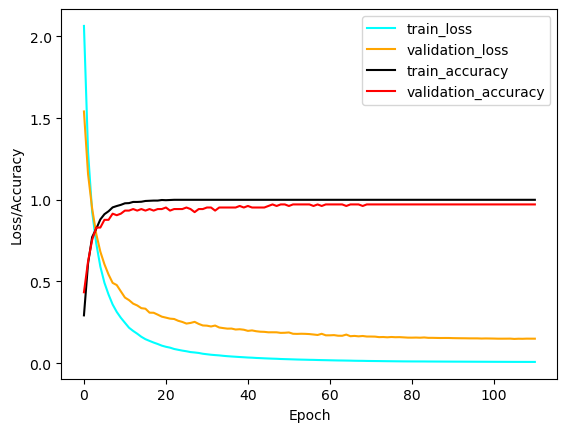

Test Accuracy: 0.9428571462631226
Test Loss: 0.18685728311538696


In [112]:
plt.plot(history.history['loss'], label='train_loss', color = 'Cyan')
plt.plot(history.history['val_loss'], label='validation_loss', color = 'Orange')
plt.plot(history.history['accuracy'], label='train_accuracy', color = 'black')
plt.plot(history.history['val_accuracy'], label='validation_accuracy', color = 'red')
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss/Accuracy")
plt.show()

model_save_path = 'E:\\University\\FYP Stuff\\Models For SkinTone Recognition\\Skintone_Recognition_Multimodal1.h5'
model.save(model_save_path)

print(f"Test Accuracy: {accuracy}")
print(f"Test Loss: {loss}")

In [113]:
# Make predictions
y_pred_probs = model.predict({'image_input': X_test, 'text_input': lighting_test_onehot})
y_pred = np.argmax(y_pred_probs, axis=1)

# preds = model.predict(X_test)
# y_pred = np.argmax(preds, axis=1)

print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=classes))

4/4 [==============================] - 2s 167ms/step
Classification Report:
              precision    recall  f1-score   support

       MST 1       0.93      0.93      0.93        15
       MST 2       0.94      1.00      0.97        15
       MST 3       1.00      1.00      1.00         9
       MST 4       0.93      0.93      0.93        15
       MST 5       0.91      0.91      0.91        11
       MST 6       1.00      0.75      0.86         8
       MST 7       1.00      1.00      1.00         4
       MST 8       0.90      1.00      0.95         9
       MST 9       1.00      0.91      0.95        11
      MST 10       0.89      1.00      0.94         8

    accuracy                           0.94       105
   macro avg       0.95      0.94      0.94       105
weighted avg       0.95      0.94      0.94       105



In [119]:
print(lighting_test)

['well' 'poorly' 'well' 'well' 'well' 'poorly' 'poorly' 'well' 'poorly'
 'poorly' 'well' 'well' 'poorly' 'well' 'well' 'poorly' 'well' 'poorly'
 'poorly' 'well' 'well' 'well' 'well' 'well' 'poorly' 'well' 'poorly'
 'poorly' 'poorly' 'poorly' 'poorly' 'well' 'well' 'well' 'poorly' 'well'
 'poorly' 'well' 'well' 'poorly' 'well' 'well' 'well' 'poorly' 'well'
 'well' 'well' 'poorly' 'poorly' 'well' 'poorly' 'poorly' 'poorly' 'well'
 'poorly' 'poorly' 'poorly' 'well' 'well' 'well' 'well' 'poorly' 'well'
 'well' 'well' 'well' 'poorly' 'poorly' 'poorly' 'poorly' 'well' 'well'
 'well' 'well' 'well' 'well' 'well' 'well' 'well' 'well' 'well' 'well'
 'well' 'well' 'poorly' 'poorly' 'well' 'poorly' 'well' 'well' 'well'
 'poorly' 'poorly' 'poorly' 'well' 'poorly' 'poorly' 'poorly' 'well'
 'well' 'poorly' 'poorly' 'poorly' 'well' 'poorly']


In [117]:
print(lighting_test_onehot)

[[0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0.

In [114]:
print('success')

success
